# Projekt "Przewidywana długość życia" -  RAPORT 

AUTORZY:

Patrycja Szczepaniak, 286668

Anna Pręgowska, 262892

## Wstęp

Dane, które wykorzystamy zostały już obrobione w poprzedniej części projektu (analizie eksploracyjnej). Z danych został również usunięty atrybut BMI ze względu na nieujednolicone wartości.

Zdecydowałyśmy się na wykorzystanie metody regularyzacji Lasso podczas regresji, ponieważ posiadamy względnie dużo atrybutów, które mogłyby mieć wpływ na końcowy wynik.

### Import danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_curve
from math import sqrt

In [17]:
data_file = pd.read_csv('processed_data.csv')
data = pd.DataFrame(data_file)
data.describe()

Year  Life expectancy  Adult Mortality  infant deaths  \
count  2492.000000      2492.000000      2492.000000    2492.000000   
mean   2007.515249        69.593485       159.840389      31.039326   
std       4.607885         9.481400       123.808663     126.495950   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.700000        71.000000       0.000000   
50%    2008.000000        72.400000       138.000000       2.000000   
75%    2012.000000        76.000000       222.000000      19.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B        Measles  \
count  2492.000000             2492.000000  2492.000000    2492.000000   
mean      4.598169              868.262755    78.962677    2340.155698   
std       4.037524             2132.344259    24.284652   11082.019582   
min       0.010000                0.000000     2.000000       0.000000   
25%       0.850000               22.485232    74.000000       0.000000   
50%       3.880000              115.659542    88.000000      15.000000   
75%       7.622500              569.058337    96.000000     341.000000   
max      17.870000            19479.911610    99.000000  212183.000000   

       under-five deaths        Polio  Total expenditure   Diphtheria  \
count        2492.000000  2492.000000        2492.000000  2492.000000   
mean           43.080257    82.552941           5.871879    82.549329   
std           171.977767    23.309641           2.374790    23.442473   
min             0.000000     3.000000           0.370000     2.000000   
25%             0.000000    78.000000           4.240000    79.000000   
50%             3.000000    93.000000           5.755000    93.000000   
75%            24.000000    97.000000           7.472167    97.000000   
max          2500.000000    99.000000          17.240000    99.000000   

          HIV/AIDS            GDP    Population  thinness 10-19 years  \
count  2492.000000    2492.000000  2.492000e+03           2492.000000   
mean      1.661838    7511.233289  3.694421e+07              4.824814   
std       4.634394   14256.064423  1.441706e+08              4.480241   
min       0.100000       1.681350  1.082100e+04              0.100000   
25%       0.100000     472.871238  2.095320e+06              1.600000   
50%       0.100000    1817.507570  7.680320e+06              3.300000   
75%       0.700000    5901.100972  2.175930e+07              7.100000   
max      43.500000  119172.741800  1.371220e+09             27.700000   

       thinness 5-9 years  Income composition of resources    Schooling  
count         2492.000000                      2492.000000  2492.000000  
mean             4.864278                         0.634204    12.129298  
std              4.571415                         0.211778     3.342947  
min              0.100000                         0.000000     0.000000  
25%              1.600000                         0.493750    10.200000  
50%              3.300000                         0.686500    12.400000  
75%              7.100000                         0.788000    14.500000  
max             28.600000                         0.948000    20.700000

### Wybór cech

Stworzenie wskaźników

In [18]:
data['child_immunization_index'] = (data['Polio'] * data['Diphtheria'] * data['Hepatitis B'])/100 #procenty
data['child_life_conditions_index'] = data['Schooling'] / (1 + data['thinness 5-9 years'] * data['Alcohol'])
data['country_development_index'] = data['Schooling'] * data['Income composition of resources'] * data['Total expenditure'] #procenty

Bierzemy wszystkie atrybuty oprócz 'Life expectancy'.

In [19]:
features = list(data.columns)

for i in ["Life expectancy", "Continent", "Country", "infant deaths", "thinness 10-19 years", "percentage expenditure", "Income composition of resources"]:
    features.remove(i) 

features

['Year',
 'Status',
 'Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 'Measles',
 'under-five deaths',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness 5-9 years',
 'Schooling',
 'child_immunization_index',
 'child_life_conditions_index',
 'country_development_index']

In [20]:
mapped_values = list()
mapped_data = data.copy()
for col in ['Status']:
    values_of_col = mapped_data[col].unique()
    mapped = dict(zip(values_of_col, range(len(values_of_col))))
    mapped_values.append(mapped)
    mapped_data = mapped_data.applymap(lambda s: mapped.get(s) if s in mapped else s)
    
X = mapped_data[features] #.drop(features, axis=1)
y = mapped_data["Life expectancy"]

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  #, stratify=y)

In [22]:
lam=5#lasso;0.08
lambdas= []
lambdas.append(lam)
while lam > 0.001:
    lam=(lam-0.1)
    lambdas.append(lam)

lambdas = lambdas[::-1]

In [23]:

model_all = linear_model.Lasso(normalize=True)
grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : lambdas}], scoring='neg_mean_squared_error', 
                             return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)
best_model_all = grid_search.best_estimator_
# best_score = grid_search.best_score_

predicted_all = best_model_all.predict(X_test)
print("RMSE= {}".format(sqrt(mean_squared_error(y_test, predicted_all))))

# print(best_score)
# print(grid_search.best_score_)

RMSE= 3.8894407943730553


In [24]:
# coefs={}
# for a in lambdas:
#     model_all = linear_model.Ridge(alpha=a, normalize=True)
#     grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : [a]}], scoring='neg_mean_squared_error', 
#                                  return_train_score=True, cv=5)
#     grid_search.fit(X_train, y_train)
#     best_model_all = grid_search.best_estimator_
#     best_score = grid_search.best_score_
#     coefs[a] = best_model_all.coef_
    


In [25]:
# plt.figure(dpi=200)
# plt.plot(coefs.keys(), coefs.values())


In [26]:
cv = grid_search.cv_results_

coefs = best_model_all.coef_
alphas = [ d["alpha"] for d in cv["params"]]
rmse_test = [sqrt(-score) for score in cv["mean_test_score"]]
rmse_train = [sqrt(-score) for score in cv["mean_train_score"]]

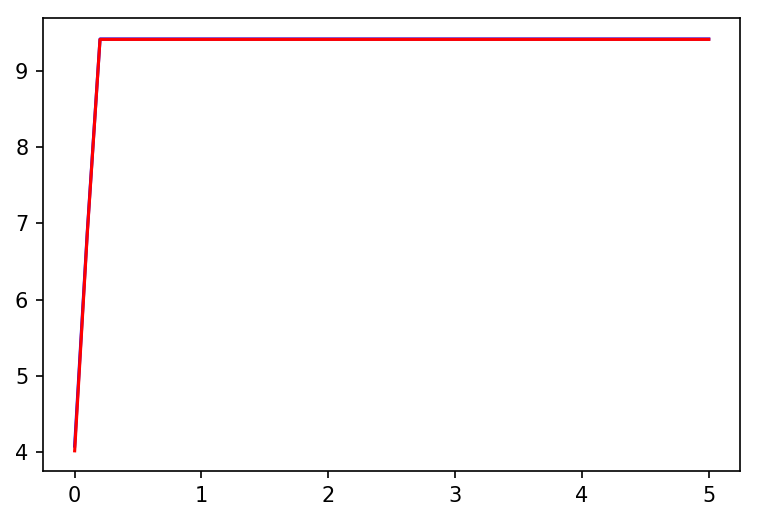

In [27]:
plt.figure(dpi=150)

# plt.plot(alphas, rmse_test, color='blue')
# plt.figure(dpi=150)
# plt.plot(alphas, rmse_train, color='red')

plt.plot(lambdas, rmse_test, color="blue")
plt.plot(lambdas, rmse_train, color="red")


In [28]:
#arr = []

cecha:  Status 
	ma wartość :  1.35299
cecha:  Schooling 
	ma wartość :  0.95045
cecha:  HIV/AIDS 
	ma wartość :  -0.59113
cecha:  Total expenditure 
	ma wartość :  -0.33569
cecha:  Alcohol 
	ma wartość :  -0.24561
cecha:  thinness 5-9 years 
	ma wartość :  -0.19629
cecha:  child_life_conditions_index 
	ma wartość :  -0.19306
cecha:  country_development_index 
	ma wartość :  0.04636
cecha:  Diphtheria 
	ma wartość :  0.03576
cecha:  Year 
	ma wartość :  -0.03258
cecha:  Polio 
	ma wartość :  0.01864
cecha:  Adult Mortality 
	ma wartość :  -0.01589
cecha:  Hepatitis B 
	ma wartość :  -0.01538
cecha:  under-five deaths 
	ma wartość :  -0.00269
cecha:  child_immunization_index 
	ma wartość :  0.0001
cecha:  GDP 
	ma wartość :  6e-05
cecha:  Measles 
	ma wartość :  -5e-05
cecha:  Population 
	ma wartość :  0.0


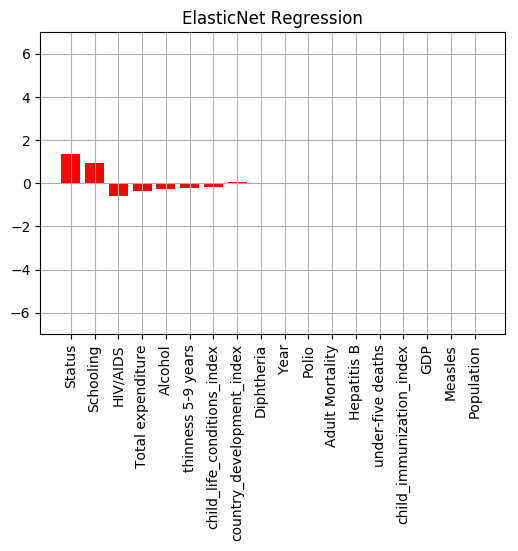

In [29]:

chosen_ =  {} #select_coefs(best_model_all, all_features)
for param, coef in zip(features, best_model_all.coef_):
    #if coef > 0:
    chosen_[coef] = param
    
sorted_ = sorted(chosen_.keys(), key=abs, reverse = True)

for key in sorted_:
    print("cecha: ", chosen_[key], "\n\tma wartość : ", round(key, 5))

plt.figure(dpi=100)
plt.bar([chosen_[key] for key in sorted_], sorted_, color="red")
plt.ylim(-7, 7)
plt.grid()
plt.title("ElasticNet Regression")
plt.xticks(rotation=90)

arr.append(chosen_.keys())


In [30]:
pams=pd.DataFrame(arr ,columns=chosen_.values())
pams.head()

Year    Status  Adult Mortality   Alcohol  Hepatitis B   Measles  \
0 -0.032582  1.352993        -0.015892 -0.245608     -0.01538 -0.000054   
1 -0.032582  1.352993        -0.015892 -0.245608     -0.01538 -0.000054   

   under-five deaths     Polio  Total expenditure  Diphtheria  HIV/AIDS  \
0          -0.002694  0.018642          -0.335692    0.035758 -0.591126   
1          -0.002694  0.018642          -0.335692    0.035758 -0.591126   

        GDP    Population  thinness 5-9 years  Schooling  \
0  0.000055  6.592240e-09           -0.196286   0.950451   
1  0.000055  6.592240e-09           -0.196286   0.950451   

   child_immunization_index  child_life_conditions_index  \
0                  0.000102                    -0.193065   
1                  0.000102                    -0.193065   

   country_development_index  
0                   0.046364  
1                   0.046364

#### Dla poszczególnych kontynentów

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Asia - RMSE= 2.5180880133549848


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Europe - RMSE= 2.509444060975376


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Africa - RMSE= 3.7973815997161817


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


North America - RMSE= 3.761033648414916


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


South America - RMSE= 1.3912493604049208


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Oceania - RMSE= 2.6577241543195007


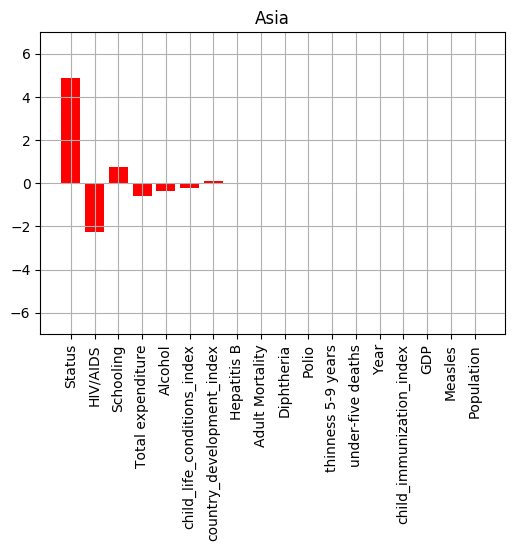

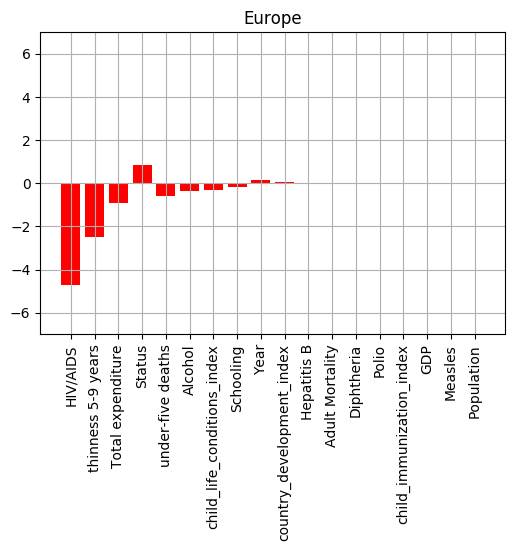

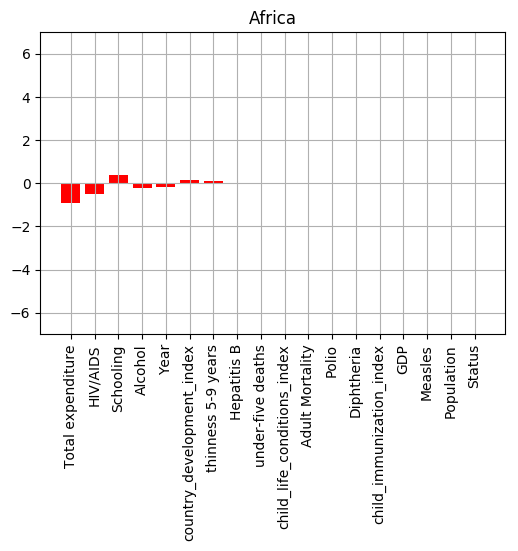

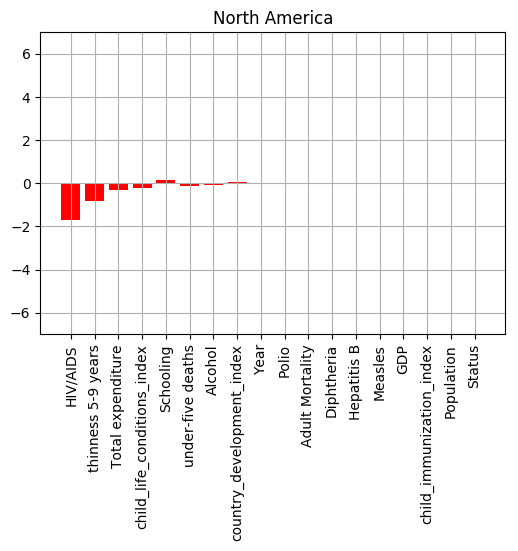

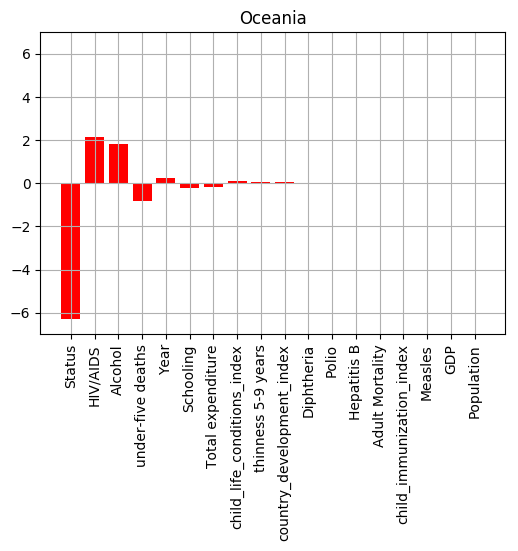

In [40]:
models = {}
for c in mapped_data.Continent.unique():
    conti_data = mapped_data.loc[mapped_data.Continent == c]
    
    X_train, X_test, y_train, y_test = train_test_split(conti_data[features], conti_data["Life expectancy"], test_size=0.2, random_state=0)  
    
    model_all = linear_model.Ridge(normalize=True)
    grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : lambdas}], scoring='neg_mean_squared_error', 
                                 return_train_score=True, cv=5)
    grid_search.fit(X_train, y_train)
    models[c] = grid_search.best_estimator_
    # best_score = grid_search.best_score_

    predicted_all = models[c].predict(X_test)
    print("{} - RMSE= {}".format(c, sqrt(mean_squared_error(y_test, predicted_all))))
    
    chosen_ =  {} #select_coefs(best_model_all, all_features)
    
    for param, coef in zip(features, models[c].coef_):
        #if coef is not 0:
        chosen_[coef] = param

    sorted_ = sorted(chosen_.keys(), key=abs, reverse = True)

#     for key in sorted_:
#         print("cecha: ", chosen_[key], "\n\tma wartość : ", key)
        
    plt.figure(dpi=100)
    plt.title(c)
    plt.bar([chosen_[key] for key in sorted_], sorted_, color="red")
    plt.ylim(-7, 7)
    plt.grid()
    plt.xticks(rotation=90)

